In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import pandas as pd
from network import Network
import matplotlib.pyplot as plt

First, read in problem parameters. These can come from any source, but they should be reshaped into `np.array` objects with dimensions specified in the docstring of `sim`.

In [2]:
# System base in MVA, taken from PowerWorld. Used to convert from MW to per-unit.
base = 100

# Key/value pairs are the names and contents of the sheets in the excel model data
model_df = pd.read_excel('Example11_9_Network_Model_Jul19.xlsx', sheet_name=None)

# The initial conditions of the demand curves
load = model_df['LoadProfiles'].set_index('Date')
load.index+=pd.TimedeltaIndex(load.HE-1, unit='h')
load = load.drop(columns='HE')
demand = np.array(load.loc[:,load.columns.str.contains('Load')]).T/base
price = np.array(load.loc[:,load.columns.str.contains('Price')]).T

# Generation profiles for intermittant sources
int_gen = pd.read_excel('Normalized generation profiles.xlsx', sheet_name='Normalized', index_col=0)
int_gen.index+=pd.TimedeltaIndex(int_gen.HE-1, unit='h')
int_gen = int_gen.drop(columns='HE')
int_gen = int_gen.loc[load.index, model_df['Gen']['Type']]
int_gen = np.array(int_gen*np.array(model_df['Gen']['Installed MW'])).T/base

# Process Ybus matrix
Y = model_df['YBus']
Y = Y.drop(columns=['Number', 'Name'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = model_df['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = (P_line+P_line.T)/base

# The buses with generators and loads
loads = np.array(model_df['Load']['Number of Bus']-1)
generators = np.array(model_df['Gen']['Number of Bus']-1)

# Number of timesteps to fully charge/discharge storage
b_duration = 4

# Elasticity
epsilon = -0.5*np.ones((len(loads), int_gen.shape[1]))

# Dispatchable generator costs
cost_lin = np.array([10,8,12])
cost_quad=np.array([.016,0.18,0.18])

Instantiate model

In [3]:
model = Network(
    loads=loads,
    generators=generators,
    B=B,
    p_g_int_max=int_gen,
    p_g_dis_min=np.array([0,0,0])/base,
    p_g_dis_max=np.array(model_df['Gen']['Installed MW'])/base,
    epsilon=epsilon,
    price=price,
    demand=demand,
    b_total=2000/base,
    b_duration=4,
    p_line_max=P_line,
    cost_lin=cost_lin,
    cost_quad=cost_quad,
    int_gen_ratio=0.9,
    voll=price*2
)

Solve model

In [4]:
model.solve()
opf = model.opf
output = {var.name(): var.value for var in opf.variables()}

A demonstration of how to visualize the results. Other variables can also be retrieved, such as transmission constraints and voltage angles.

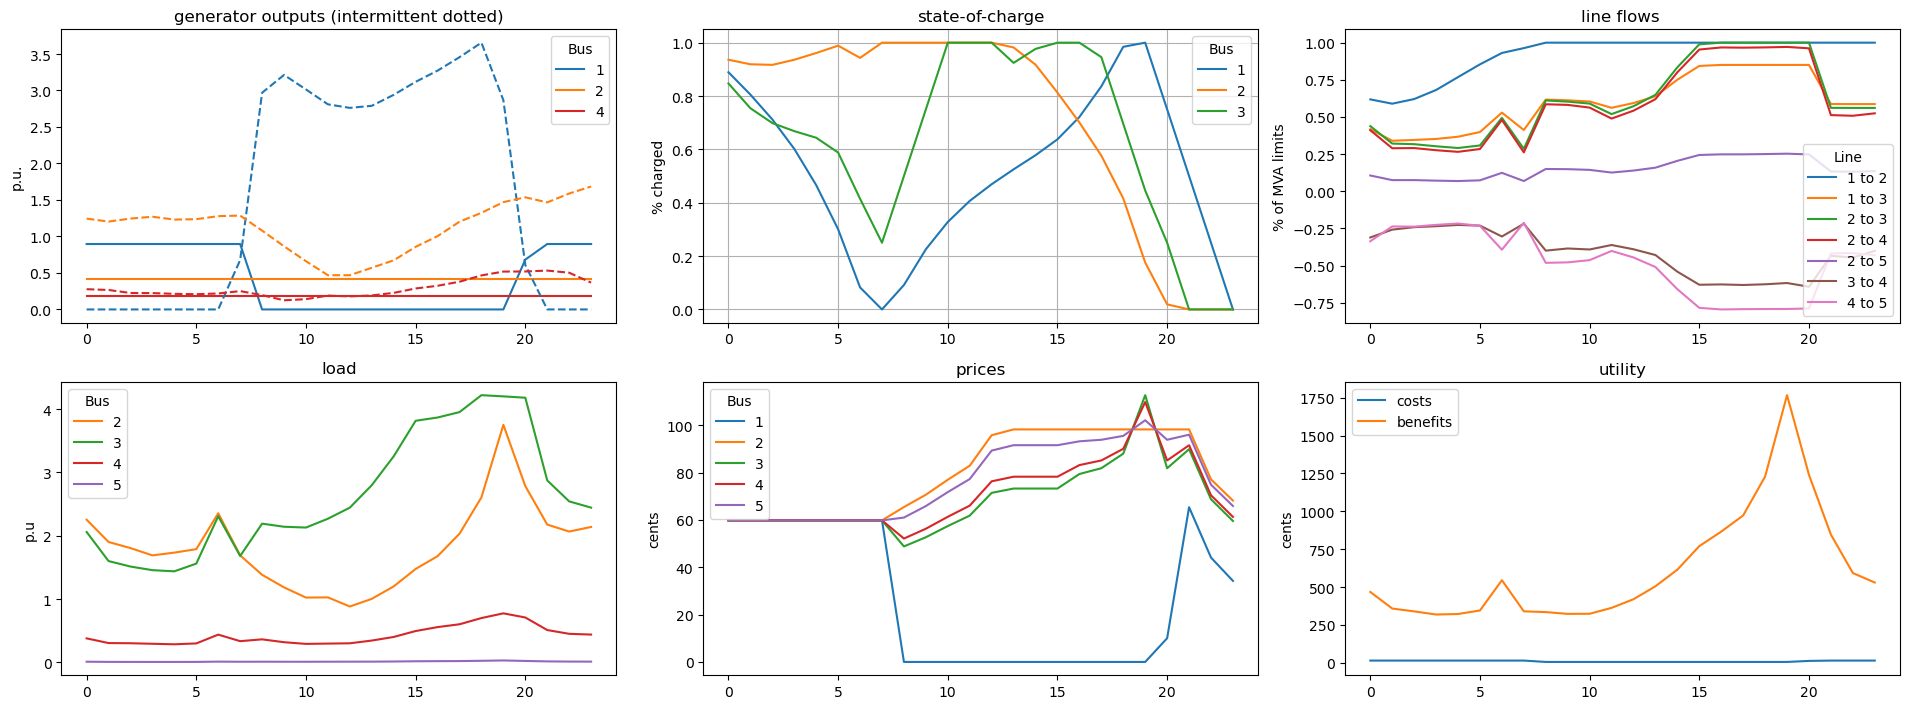

In [5]:
fig, ax = plt.subplots(2,3)

# The prices are the negative of the dual of the first constraint
ax[1,1].plot(-opf.constraints[0].dual_value.T)
ax[1,1].set_ylabel('cents')
ax[1,1].set_title('prices')
colors = np.array([line.get_color() for line in ax[1,1].lines])
ax[1,1].legend(range(1,N+1), title='Bus')

# Generators
ax[0,0].plot(output['p_g_dis'].T)
ax[0,0].plot(output['p_g_int'].T,'--')
[line.set_color(colors[generators][i%len(generators)]) for i, line in enumerate(ax[0,0].lines)]
ax[0,0].set_ylabel('p.u.')
ax[0,0].set_title('generator outputs (intermittent dotted)')
ax[0,0].legend(generators+1, title='Bus')

# Storage
idx = output['b']>=1e-3
ax[0,1].plot((output['b_0'][idx]+np.cumsum(output['p_b'][idx,:],axis=1).T)/output['b'][idx])
ax[0,1].set_ylabel('% charged')
ax[0,1].set_title('state-of-charge')
ax[0,1].legend(range(1,N+1), title='Bus')
ax[0,1].grid()

congestion = [
    B*(angle_t[:,np.newaxis]-angle_t[np.newaxis,:])
    for angle_t in output['angle'].T
]
idx = np.array(np.where(P_line != 0))
[
    ax[0,2].plot(
        [
            M[i,j]/P_line[i,j]
            for M in congestion  
        ],
        label=f'{i+1} to {j+1}'
    ) for i, j in idx[:,idx[0] < idx[1]].T
]
ax[0,2].set_title('line flows ')
ax[0,2].set_ylabel('% of MVA limits')
ax[0,2].legend(title='Line')

# Loads
ax[1,0].plot((output['p_d']).T)
[line.set_color(colors[loads][i%len(loads)]) for i, line in enumerate(ax[1,0].lines)]
ax[1,0].set_ylabel('p.u')
ax[1,0].set_title('load')
ax[1,0].legend(loads+1, title='Bus')

# Utility
ax[1,2].plot(cost_lin@output['p_g_dis']+cost_quad@output['p_g_dis']**2, label='costs')
ax[1,2].plot(
    np.sum(model.epsilon*model.price*((output['p_d']+model.delta)**(1/model.epsilon+1)-model.delta**(1/epsilon+1))/(model.epsilon+1)/(model.demand+model.delta)**(1/epsilon),axis=0), 
    label='benefits'
)
ax[1,2].set_ylabel('cents')
ax[1,2].set_title('utility')
ax[1,2].legend()

fig.set_size_inches(fig.get_size_inches()*[3,1.5])
fig.tight_layout()
fig.show()

Visualization of constant and quasi-constant demand functions

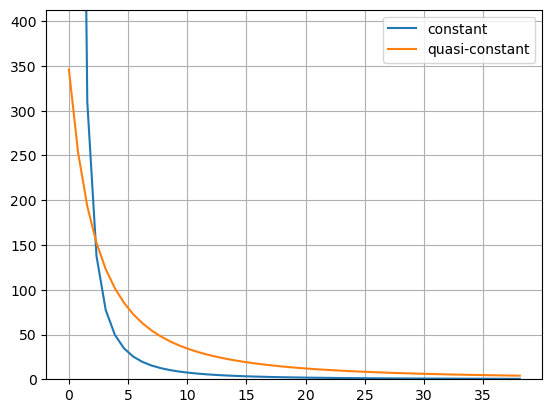

In [6]:
j = price.max(axis=0).argmax()
i = price[:,j].argmax()
idx = (i,j)
f_constant = lambda d: model.price[idx]*(d/model.demand[idx])**(1/model.epsilon[idx])
f_quasi_constant = lambda d: model.price[idx]*((d+model.delta[idx])/(model.demand[0,0]+model.delta[idx]))**(1/model.epsilon[idx])
d = np.linspace(0,20*model.demand[idx])
plt.plot(d[1:],f_constant(d[1:]))
plt.plot(d,f_quasi_constant(d))
ax = plt.gca()
ax.set_ylim((0,model.voll[idx]))
plt.grid()
plt.legend(('constant','quasi-constant'))
plt.show()